In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.util import random_noise

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
TRAIN_IMG_DIR = '/content/drive/MyDrive/infosys_oil_detection/images/train/'
TRAIN_MASK_DIR = '/content/drive/MyDrive/infosys_oil_detection/masks/masks/train'
VAL_IMG_DIR = '/content/drive/MyDrive/infosys_oil_detection/images/val/'
VAL_MASK_DIR = '/content/drive/MyDrive/infosys_oil_detection/masks/masks/val'


In [ ]:
# Target settings for preprocessing
TARGET_SIZE = (256, 256)  # (Width, Height)

def load_file_pairs(img_dir, mask_dir):
    """
    Matches images to masks by filename.
    Assumes filenames are identical or predictable.
    """
    img_paths = sorted(glob.glob(os.path.join(img_dir, '*.png')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')))

    # Basic check to ensure lists are not empty
    if not img_paths:
        print(f"⚠️ Warning: No images found in {img_dir}")
    if not mask_paths:
        print(f"⚠️ Warning: No masks found in {mask_dir}")

    return img_paths, mask_paths

# Load data lists
train_imgs, train_masks = load_file_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR)

In [ ]:
# ==========================================
# 2. EDA TASKS
# ==========================================

def visualize_sample(img_path, mask_path, title_prefix="Raw"):
    """
    Loads and displays an image, its mask, and an overlay.
    """
    # Load Image (Use UNCHANGED to support 16-bit SAR if needed)
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    # Load Mask (Load as grayscale)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        return None, None

    # Handle multi-channel images (convert BGR to RGB if needed)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Check Dimensions
    print(f"--- {title_prefix} Analysis ---")
    print(f"Image Shape: {image.shape} | Data Type: {image.dtype}")
    print(f"Mask Shape:  {mask.shape} | Data Type: {mask.dtype}")

    if image.shape[:2] != mask.shape[:2]:
        print("⚠️ ALERT: Image and Mask dimensions do not match!")

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Original Image
    if len(image.shape) == 2: # Grayscale/SAR
        ax[0].imshow(image, cmap='gray')
    else:
        ax[0].imshow(image)
    ax[0].set_title(f"{title_prefix} Image")
    ax[0].axis('off')

    # 2. Mask
    ax[1].imshow(mask, cmap='jet', alpha=0.7) # Jet cmap helps distinguish classes
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis('off')

    # 3. Overlay (Image + Mask)
    # Normalize image for display if it's 16-bit
    img_disp = image.copy()
    if img_disp.dtype != np.uint8:
        img_disp = cv2.normalize(img_disp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    ax[2].imshow(img_disp, cmap='gray')
    ax[2].imshow(mask, cmap='jet', alpha=0.3) # Overlay with transparency
    ax[2].set_title("Overlay Check")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()
    return image, mask

In [ ]:
def analyze_sar_noise(image):
    """
    Analyzes pixel intensity distribution to observe SAR speckle patterns.
    """
    plt.figure(figsize=(12, 4))

    # Histogram of pixel intensities
    plt.subplot(1, 2, 1)
    sns.histplot(image.ravel(), bins=50, kde=True, color='purple')
    plt.title("Pixel Intensity Distribution (Global)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    # Zoom into a patch to see Speckle Noise visually
    h, w = image.shape[:2]
    # Center crop 50x50
    patch = image[h//2-25 : h//2+25, w//2-25 : w//2+25]

    plt.subplot(1, 2, 2)
    if len(patch.shape) == 2:
        plt.imshow(patch, cmap='gray')
    else:
        plt.imshow(patch)
    plt.title("Zoomed Noise/Texture Pattern (50x50)")
    plt.axis('off')

    plt.show()



## 1. Initial Inspection
--- Raw Analysis ---
Image Shape: (256, 256, 3) | Data Type: uint8
Mask Shape:  (256, 256) | Data Type: uint8


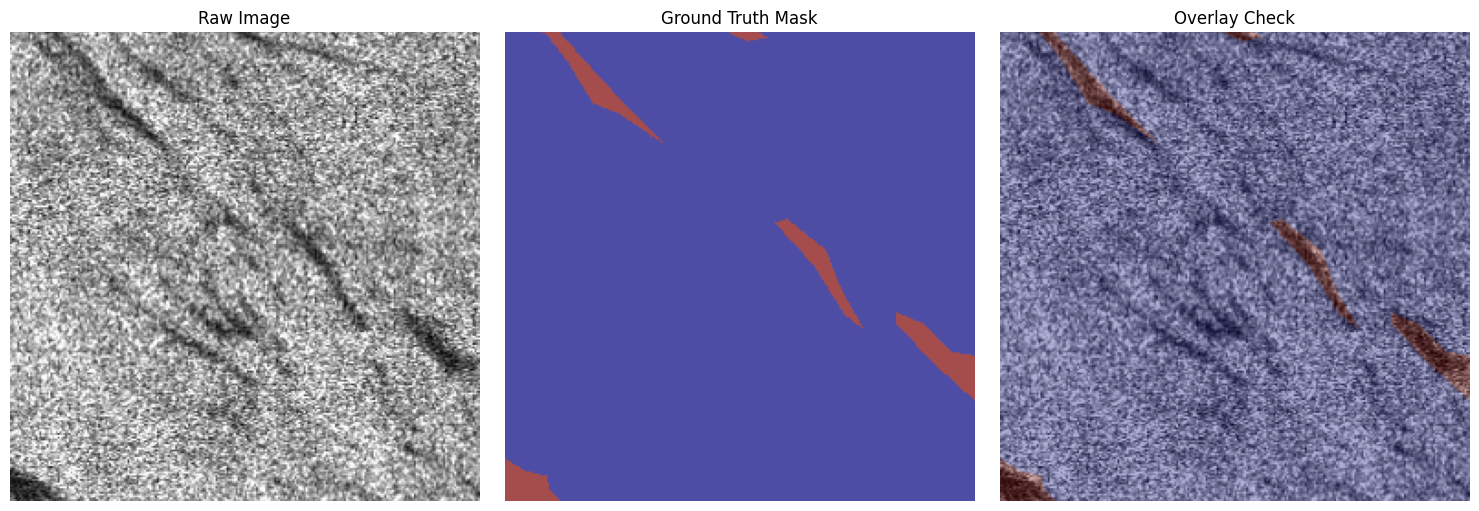


## 2. SAR Noise & Intensity Analysis


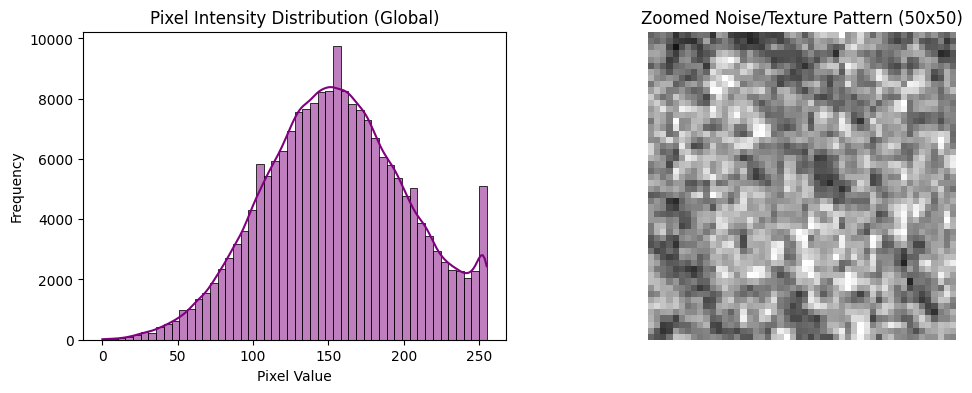

In [ ]:
# --- EXECUTE EDA ---
if train_imgs:
    # Process the first image found
    print("## 1. Initial Inspection")
    raw_img, raw_mask = visualize_sample(train_imgs[0], train_masks[0])

    if raw_img is not None:
        print("\n## 2. SAR Noise & Intensity Analysis")
        analyze_sar_noise(raw_img)


In [ ]:
def preprocess_sar_data(image, mask, target_size=(256,256)):
    """
    Correct SAR preprocessing:
    Resize → Denoise → CLAHE → Normalize
    """

    # ---------- IMAGE ----------
    # Ensure grayscale
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize
    img = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

    # Ensure uint8 (CLAHE requirement)
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Denoising (speckle-friendly)
    img = cv2.medianBlur(img, 3)

    # CLAHE (contrast enhancement)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Normalize AFTER CLAHE
    img = img.astype(np.float32) / 255.0

    # ---------- MASK ----------
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    # Force binary labels {0,1}
    mask = (mask > 0).astype(np.uint8)

    return img, mask



## 3. Preprocessing: Before vs After


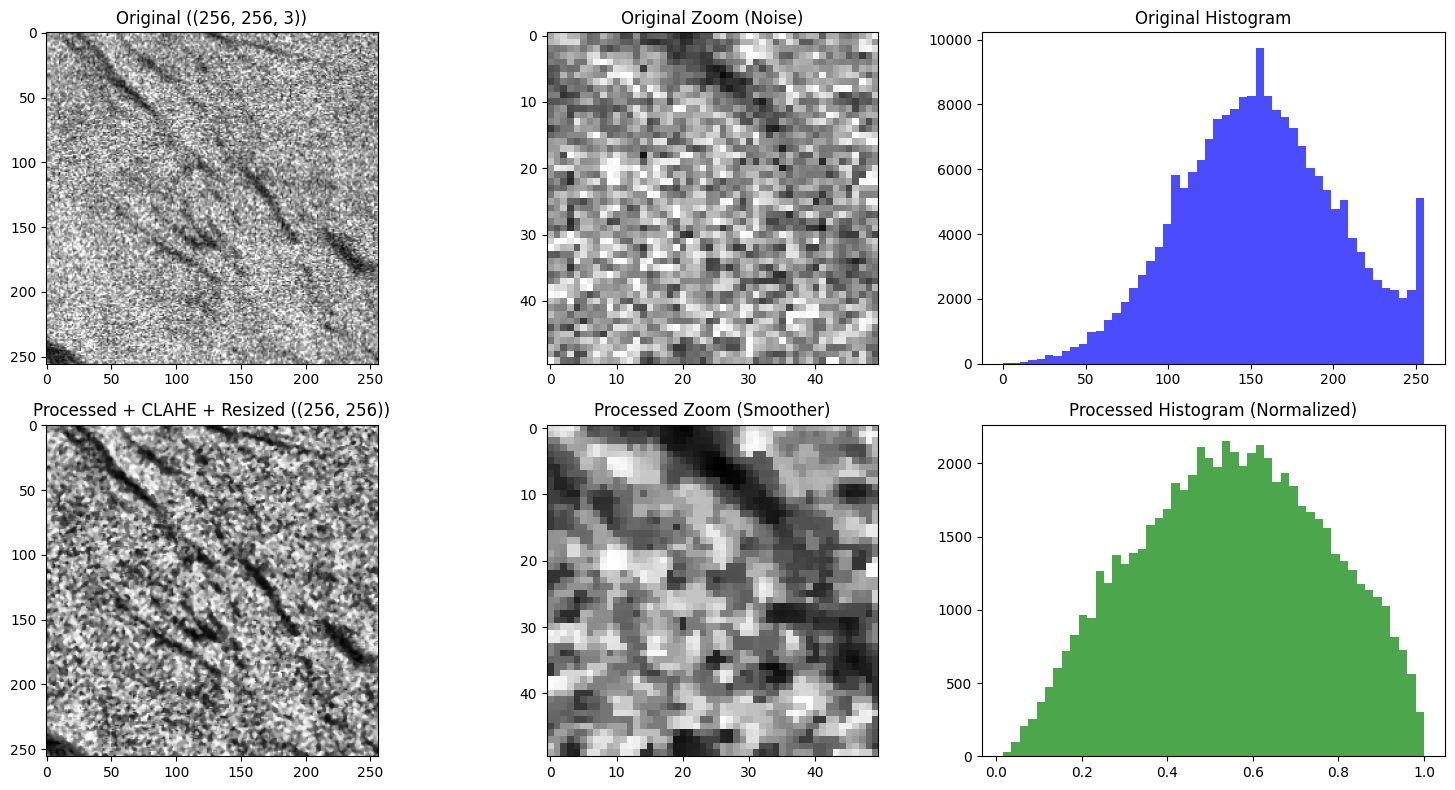


## 4. Augmentation Examples


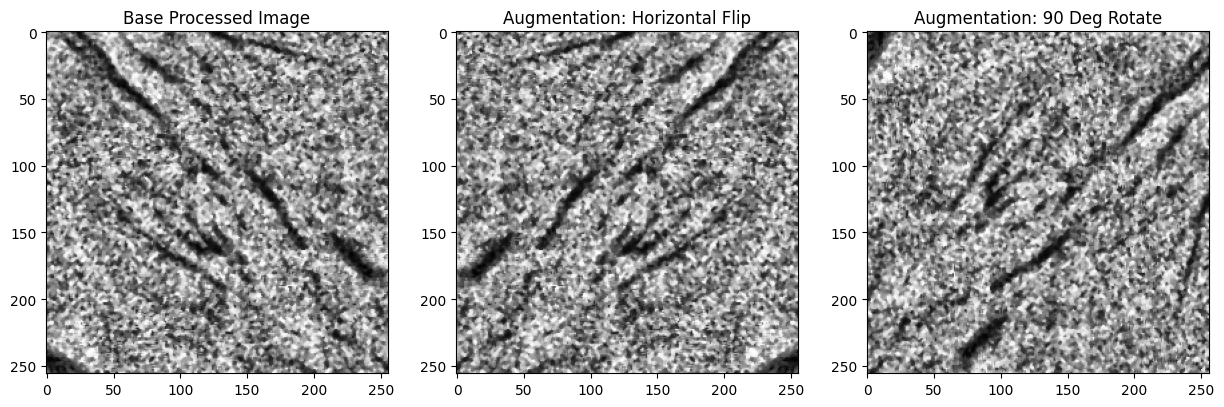

In [ ]:
def augment_data(image, mask):
    """
    Simple Augmentations: Flip and Rotation.
    """
    # Horizontal Flip
    img_flip = cv2.flip(image, 1)
    mask_flip = cv2.flip(mask, 1)

    # 90 Degree Rotation
    img_rot = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    mask_rot = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)

    return (img_flip, mask_flip), (img_rot, mask_rot)

# --- EXECUTE PREPROCESSING COMPARISON ---
if train_imgs and raw_img is not None:
    print("\n## 3. Preprocessing: Before vs After")

    # Apply pipeline
    proc_img, proc_mask = preprocess_sar_data(raw_img, raw_mask, TARGET_SIZE)

    fig, ax = plt.subplots(2, 3, figsize=(15, 8))

    # Row 1: Raw Data
    ax[0,0].imshow(raw_img, cmap='gray' if len(raw_img.shape)==2 else None)
    ax[0,0].set_title(f"Original ({raw_img.shape})")

    # Zoom in on Raw noise
    crop_raw = raw_img[50:100, 50:100]
    ax[0,1].imshow(crop_raw, cmap='gray' if len(raw_img.shape)==2 else None)
    ax[0,1].set_title("Original Zoom (Noise)")

    ax[0,2].hist(raw_img.ravel(), bins=50, color='blue', alpha=0.7)
    ax[0,2].set_title("Original Histogram")

    # Row 2: Processed Data
    ax[1,0].imshow(proc_img, cmap='gray' if len(proc_img.shape)==2 else None)
    ax[1,0].set_title(f"Processed + CLAHE + Resized ({proc_img.shape})")

    # Zoom in on Processed noise (Check Denoising)
    crop_proc = proc_img[50:100, 50:100]
    ax[1,1].imshow(crop_proc, cmap='gray' if len(proc_img.shape)==2 else None)
    ax[1,1].set_title("Processed Zoom (Smoother)")

    ax[1,2].hist(proc_img.ravel(), bins=50, color='green', alpha=0.7)
    ax[1,2].set_title("Processed Histogram (Normalized)")

    plt.tight_layout()
    plt.show()

    # --- AUGMENTATION VISUALIZATION ---
    print("\n## 4. Augmentation Examples")
    (flip_img, flip_mask), (rot_img, rot_mask) = augment_data(proc_img, proc_mask)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(proc_img, cmap='gray')
    ax[0].set_title("Base Processed Image")

    ax[1].imshow(flip_img, cmap='gray')
    ax[1].set_title("Augmentation: Horizontal Flip")

    ax[2].imshow(rot_img, cmap='gray')
    ax[2].set_title("Augmentation: 90 Deg Rotate")

    plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [ ]:
class SARDataset(Dataset):
    def __init__(self, img_paths, mask_paths, target_size=(256,256)):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.target_size = target_size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
      img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
      mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

      img, mask = preprocess_sar_data(img, mask, self.target_size)

      img = torch.tensor(img).unsqueeze(0)   # [1, H, W]
      mask = torch.tensor(mask, dtype=torch.long)
      return img, mask


In [ ]:
from sklearn.model_selection import train_test_split

train_img, val_img, train_mask, val_mask = train_test_split(
    train_imgs, train_masks, test_size=0.2, random_state=42
)

train_dataset = SARDataset(train_img, train_mask)
val_dataset   = SARDataset(val_img, val_mask)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [ ]:
import torch.nn as nn

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.middle = DoubleConv(256, 512)

        self.up3 = DoubleConv(512+256, 256)
        self.up2 = DoubleConv(256+128, 128)
        self.up1 = DoubleConv(128+64, 64)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.pool(c1))
        c3 = self.down3(self.pool(c2))

        m = self.middle(self.pool(c3))

        u3 = self.up(m)
        u3 = self.up3(torch.cat([u3, c3], dim=1))

        u2 = self.up(u3)
        u2 = self.up2(torch.cat([u2, c2], dim=1))

        u1 = self.up(u2)
        u1 = self.up1(torch.cat([u1, c1], dim=1))

        return self.out(u1)


In [ ]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)
    pred_fg = pred[:, 1]

    target_fg = (target == 1).float()

    intersection = (pred_fg * target_fg).sum(dim=(1,2))
    union = pred_fg.sum(dim=(1,2)) + target_fg.sum(dim=(1,2))

    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()


In [ ]:
criterion_ce = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
def train_epoch(loader):
    print("➡ Entered train_epoch")

    model.train()
    total_loss = 0

    for i, (img, mask) in enumerate(loader):

        img = img.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        out = model(img)

        loss = criterion_ce(out, mask) + dice_loss(out, mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    return total_loss


In [ ]:
def eval_epoch(loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for img, mask in loader:
            img, mask = img.to(device), mask.to(device)
            out = model(img)
            loss = criterion_ce(out, mask) + dice_loss(out, mask)
            total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"\n🚀 Starting Epoch {epoch+1}")

    train_loss = train_epoch(train_loader)
    val_loss   = eval_epoch(val_loader)

    print(f"✅ Epoch {epoch+1} Done")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



🚀 Starting Epoch 1
➡ Entered train_epoch
✅ Epoch 1 Done
Train Loss: 439.3888 | Val Loss: 0.5893

🚀 Starting Epoch 2
➡ Entered train_epoch
✅ Epoch 2 Done
Train Loss: 392.7701 | Val Loss: 0.5375

🚀 Starting Epoch 3
➡ Entered train_epoch
✅ Epoch 3 Done
Train Loss: 376.4062 | Val Loss: 0.5375

🚀 Starting Epoch 4
➡ Entered train_epoch
✅ Epoch 4 Done
Train Loss: 367.2772 | Val Loss: 0.5117

🚀 Starting Epoch 5
➡ Entered train_epoch
✅ Epoch 5 Done
Train Loss: 361.1708 | Val Loss: 0.5186


In [ ]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    img, mask = dataset[idx]

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(pred, dim=1).cpu().numpy()[0]

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Input SAR")

    plt.subplot(1,3,2)
    plt.imshow(mask, cmap='jet')
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='jet')
    plt.title("Prediction")

    plt.show()


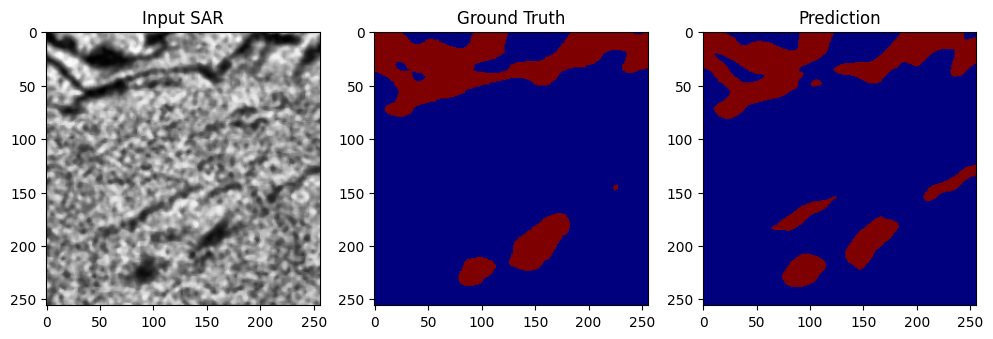

In [ ]:
visualize_prediction(model, val_dataset, idx=0)


In [ ]:
torch.save(model.state_dict(), "sar_unet_model.pth")


In [3]:
MODEL_PATH = "/content/drive/MyDrive/infosys_oil_detection/sar_unet_model.pth"